# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Importing required libraries in the top most cell.**

In [1]:
import pandas as pd
import numpy as np
import math
import json
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

**Read the json files**

In [43]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

**Checking the Portfolio data and preparing it for further process.**

In [30]:
print(portfolio.shape)
portfolio.head()

(10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [31]:
print('offer types:', portfolio.offer_type.unique())
print('difficulty levels:', portfolio.difficulty.unique())
print('rewards :',portfolio.reward.unique())
print('duration of offers:', portfolio.duration.unique())
allchannles = []
for val in portfolio.channels:
    allchannles.extend(set(val)-set(allchannles))
print('All cahnnels:', allchannles)

offer types: ['bogo' 'informational' 'discount']
difficulty levels: [10  0  5 20  7]
rewards : [10  0  5  3  2]
duration of offers: [ 7  5  4 10  3]
All cahnnels: ['email', 'social', 'mobile', 'web']


### Steps to prepare portfolio data:
**1.Renaming id as offerid.<br>
2.one hot encode channels column and remove the original column.<br>
3.One hot encode offer_type and remove the original column.**

In [32]:
def prepare_portfolio(df):
    '''
    INPUT:
        df:portfolio dataframe.
    OUTPUT:
        clean_portfolio: Cleaned portfolio data.
    '''
    df.rename(columns={'id':'offer_id'}, inplace=True)
    offertypes = pd.get_dummies(df.offer_type)
    
    channel_binarizer = MultiLabelBinarizer()
    channel_df = pd.DataFrame(channel_binarizer.fit_transform(df.channels), columns=channel_binarizer.classes_)
    
    clean_portfolio = pd.concat([df, offertypes, channel_df], axis=1)
    clean_portfolio.drop(['offer_type', 'channels'], inplace=True, axis=1)
    
    return clean_portfolio

In [33]:
clean_portfolio = prepare_portfolio(portfolio)
clean_portfolio

,reward,difficulty,duration,offer_id,bogo,discount,informational,email,mobile,social,web
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,0,1


**Checking the profile data and preparing it.**

In [34]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [35]:
print('Gender values:',profile.gender.unique())
print('Age values:', profile.age.unique())

Gender values: [None 'F' 'M' 'O']
Age values: [118  55  75  68  65  58  61  26  62  49  57  40  64  78  42  56  33  46
  59  67  53  22  96  69  20  45  54  39  41  79  66  29  44  63  36  76
  77  30  51  27  73  74  70  89  50  90  60  19  72  52  18  71  83  43
  47  32  38  34  85  48  35  82  21  24  81  25  37  23 100  28  84  80
  87  86  94  31  88  95  93  91  92  98 101  97  99]


In [36]:
den =100/profile.shape[0]

print('Gender Distribution in percent:')
print(profile['gender'].value_counts() * den)

print('\nPercentage of missing values:')
print(profile.isnull().sum()*den)

print('\nProfile missing values count:')
print(profile.isnull().sum())

Gender Distribution in percent:
M    49.905882
F    36.052941
O     1.247059
Name: gender, dtype: float64

Percentage of missing values:
gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

Profile missing values count:
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


**It appears that there is some relation between the missing values and age=118. Lets confirm this.**

In [37]:
profile118 = profile[profile['age'] == 118]
print('Missing values with age=118:\n',profile.isnull().sum())
profile118.head()

Missing values with age=118:
 gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


**Well Well, all the 2175 of the missing values are having an age=118. This makes it simpler for us to drop these rows. As gender and income both are missing we don't need to think anymore before dropping them.**

### Steps to prepare profile:
**1.Drop all the rows with age=118.<br>
2.Convert became_member_on to datetime.<br>
3.Extract year and create dummies.<br>
4.Create gender dummies<br>
5.Rename id to person**

In [38]:
def prepare_profile(df):
    '''
    INPUT:
        df: Profile dataframe
    OUTPUT:
        cleaned_profile: Cleaned profile dataframe
    '''
    df.rename(columns={'id':'person'}, inplace=True)
    drop118 = df[df['age'] ==118].index
    df = df.drop(index= drop118, axis=0).reset_index(drop=True)
    df['date'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
#     df_gender_O = df[df['gender'] == 'O'].index
#     df = df.drop(index=df_gender_O, axis=0).reset_index(drop = True)
    gender = pd.get_dummies(df.gender, prefix='gender')
    
    df['membership_year'] = df.date.dt.year
    membership_dummies = pd.get_dummies(df['membership_year'])
    
    cleaned_profile = pd.concat([df, membership_dummies,gender], axis =1)
    #cleaned_profile['gender'] = cleaned_profile['gender'].apply(lambda x: 1 if x=='M' else 0)
    cleaned_profile.drop(['became_member_on'], inplace=True, axis=1)
    
    return cleaned_profile    

In [39]:
clean_profile = prepare_profile(profile)
clean_profile.head()

,gender,age,person,income,date,membership_year,2013,2014,2015,2016,2017,2018,gender_F,gender_M,gender_O
0,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,2017,0,0,0,0,1,0,1,0,0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,2017,0,0,0,0,1,0,1,0,0
2,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26,2018,0,0,0,0,0,1,0,1,0
3,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09,2018,0,0,0,0,0,1,0,1,0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11,2017,0,0,0,0,1,0,0,1,0


**Checking the transcript data and preparing it.**

In [40]:
print(transcript.shape)
transcript.head()

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [41]:
print('Number of Unique Users: ', transcript.person.nunique())
print('Event unique values:',transcript.event.unique())
print('Time unique values:',transcript.time.unique())

Number of Unique Users:  17000
Event unique values: ['offer received' 'offer viewed' 'transaction' 'offer completed']
Time unique values: [  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594 600 606 612 618 624 630 636 642
 648 654 660 666 672 678 684 690 696 702 708 714]


In [42]:
print('Null values in the transcript data:')
transcript.isnull().sum()

Null values in the transcript data:


person    0
event     0
value     0
time      0
dtype: int64

In [43]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

**It appears that there are four different 'keys' used in the dictionary namely: offer id, offer_id, amount, reward.<br>
After checking into the data a pattern was found that for the events "offer received" and "offer viewed" the value column contains dictionary with key as "offer id" while for event "offer completed" it has "offer_id". 
It was also found that on event "transaction" the value column has "amount" as key.**


###  Steps to prepare transcript:
**1.Select records of the customers present in cleaned profile.<br>
2.Convert time column to number of days (i.e., divide by 24).<br>
3.Separate transaction event from other as we are more interested in other events right now<br>
4.Remove the dictionary format of the "value" column.**

In [239]:

customers = clean_profile.person
print('Number of unique profile ids in cleaned profile data:',customers.shape[0])

Number of unique profile ids in cleaned profile data: 14825


In [240]:
def offer_separator(customers, transcript):
    '''
    INPUT:
        customers: list of ids of customers in cleaned profile
        transcript: transcript dataframe
    OUTPUT:
        transactions: dataframe with tansaction event rows
        offers: dataframe containing events except transaction
    '''
    transcript_cust = transcript[transcript['person'].isin(customers)]
    transcript_cust['time'] /=24.0
    transactions = transcript_cust[transcript_cust['event']=='transaction'].reset_index(drop=True)
    transactions['amount']=transactions['value'].apply(lambda x: list(x.values())[0])
    transactions.drop(columns =['event','value'], axis=1, inplace=True)
#     transactions.head()
    offers = transcript_cust[transcript_cust['event']!='transaction'].reset_index(drop=True)
    event = offers.event.apply(lambda x : re.match('^offer ([a-z]+$)',x).groups(1)[0])
    event = pd.get_dummies(event)
    offers['offer_id']=offers['value'].apply(lambda x: list(x.values())[0])
    offers = pd.concat([offers,event],axis=1)
    offers.drop(columns =['event','value'],inplace=True)
#     offers.head()
    return transactions, offers

### Prepare data for EDA and model:
**1.Get the offer event data except for transaction events from transcript.<br>
2.Separate the offers by events i.e into 3 sub datas.<br>
3.An offer will be considered successful if it is received by a customer, and from the received time it is viewed and completed within the offer duration. An informational offer will be considered successful when it is received and viewed.<br>
4.Go through offers received by each customer and check for success of each offer received.<br>
5.Create a dataframe and store it as a csv.**

In [241]:
def clean_offer_data(customers, 
                     transcript, 
                     clean_portfolio, 
                     clean_profile,
                     path = "./data/processed_offers.csv"):
    '''
    INPUT:
        customers: list of ids of customers in cleaned profile
        transcript: transcript dataframe
        clean_portfolio: clean portfolio dataframe
        clean_profile: clean profile dataframe
        path: path to save the processed data as a csv file
    
    OUTPUT:
        offer_final_data: Processed data for modelling
    '''
    transactions, offers = offer_separator(customers, transcript)
    
    event_drop = ['completed','received','viewed']
    #separate the data by 3 events
    offer_received = offers[offers.received == 1].reset_index(drop = True)
    offer_viewed = offers[offers.viewed == 1].reset_index(drop = True)
    offer_completed = offers[offers.completed == 1].reset_index(drop = True)
    #drop unnecessary columns
    offer_received.drop(columns = event_drop,inplace = True)
    offer_viewed.drop(columns= event_drop,inplace=True)
    offer_completed.drop(columns= event_drop,inplace=True)

    concated_data = []
    #loop through each customer id
    for id in customers:
        
        customer = clean_profile[clean_profile['person']==id]
        #3 events data for a customer
        offers_received = offer_received[offer_received['person']==id].reset_index(drop=True)
        offers_viewed = offer_viewed[offer_viewed['person']==id].reset_index(drop=True)
        offers_completed = offer_completed[offer_completed['person']==id].reset_index(drop=True)
        
        #store records after processing
        customer_records =[]
        for rec_off in range(offers_received.shape[0]):
            cur_offer = offers_received.iloc[rec_off]
            id_cur_offer = cur_offer['offer_id']
            
            #offer details
            offer_details = clean_portfolio.loc[clean_portfolio.offer_id == id_cur_offer]
            off_duration = offer_details.duration.values[0]
            is_informational = offer_details.informational.values[0].astype(bool)
            
            off_received_time = cur_offer['time']
            off_end_time = off_received_time + off_duration
            
            #create a final offer row
            offer_final = {
                           'time': off_received_time
                           }
            offer_final.update(cur_offer.to_dict())
            offer_final.update(customer.iloc[0].to_dict())
            offer_final.update(offer_details.iloc[0].to_dict())

            #offer will be considered successful if viewed and completed within
            #the end time or received and viewed if informational
            completed_time = offers_completed.loc[offers_completed.offer_id == id_cur_offer]['time']
            viewed_time = offers_viewed.loc[offers_viewed.offer_id == id_cur_offer]['time']
            
            if is_informational:
                if viewed_time.empty:
                    offer_final.update({'offersuccess':0})
                elif ((viewed_time.values[0]>=off_received_time) &(viewed_time.values[0]<=off_end_time)):
                    offer_final.update({'offersuccess':1})
                else:
                    offer_final.update({'offersuccess':0})
            else:
                if completed_time.empty:
                    offer_final.update({'offersuccess':0})
                else:
                    if viewed_time.empty:
                        offer_final.update({'offersuccess':0})
                    else:    
                        if (((completed_time.values[0]>=off_received_time) &(completed_time.values[0]<=off_end_time))
                            & ((viewed_time.values[0]>=off_received_time) &(viewed_time.values[0]<=off_end_time))):
                            offer_final.update({'offersuccess':1})
                        else:
                            offer_final.update({'offersuccess':0})
            #print(offer_final)
            customer_records.append(offer_final)

        concated_data.extend(customer_records)

    offer_final_data = pd.DataFrame(concated_data)
    offer_final_data.to_csv(path)
    
    return offer_final_data

In [242]:
#comment this line if you have already generated a processed data csv
offer_final_data = clean_offer_data(customers, transcript, clean_portfolio, clean_profile)


In [2]:
#uncomment this line if you already have a processed data csv
offer_final_data = pd.read_csv("data/processed_offers.csv")
del offer_final_data['Unnamed: 0']

**Lets check how the offers stand after getting cleaned data**

In [32]:
offersuccess_rate = offer_final_data.groupby('offer_id')['offersuccess'].agg(['sum','count']).reset_index()
offersuccess_rate['success_rate'] = offersuccess_rate['sum']/offersuccess_rate['count']*100
offersuccess_rate=offersuccess_rate.sort_values(by='success_rate')
offersuccess_rate

,offer_id,sum,count,success_rate
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1410,6726,20.963426
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,2243,6685,33.552730
2,2906b810c7d4411798c6938adc9daaa5,2226,6631,33.569597
7,ae264e3637204a6fb9bb56bc8210ddfd,2681,6683,40.116714
4,4d5c57ea9a6940dd891ad53e9dbe8da0,2646,6593,40.133475
3,3f207df678b143eea3cee63160fa8bed,2771,6657,41.625357
8,f19421c1d4aa40978ebb69ca19b0e20d,3284,6576,49.939173
1,2298d6c36e964ae4a3e7e9706d1fb8c2,3940,6655,59.203606
9,fafdcd668e3743c1bb461111dcafc2a4,4083,6652,61.380036
5,5a8bc65990b245e5a138643cd4eb9837,4575,6643,68.869487


Text(0.5, 1.0, 'Success Comparison')

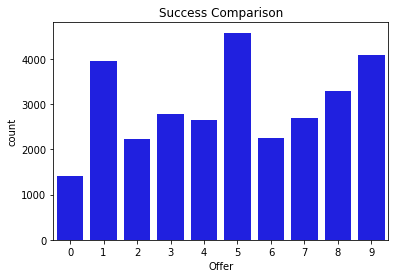

In [41]:
sns.barplot(x=offersuccess_rate.index,y=offersuccess_rate['sum'],color="blue")
plt.xlabel('Offer')
plt.ylabel('count')
plt.title('Success Comparison')

Text(0.5, 1.0, 'How many customers received an offer')

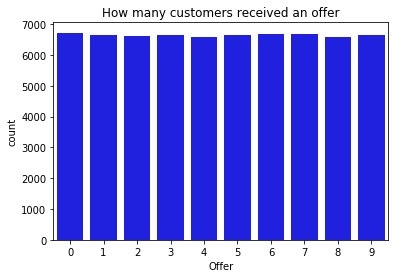

In [42]:
sns.barplot(x=offersuccess_rate.index,y=offersuccess_rate['count'],color="blue")
plt.xlabel('Offer')
plt.ylabel('count')
plt.title('How many customers received an offer')

In [46]:
pd.merge(offersuccess_rate, clean_portfolio,on='offer_id')

,offer_id,sum,count,success_rate,reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1410,6726,20.963426,5,20,10,0,1,0,1,0,0,1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,3940,6655,59.203606,3,7,7,0,1,0,1,1,1,1
2,2906b810c7d4411798c6938adc9daaa5,2226,6631,33.569597,2,10,7,0,1,0,1,1,0,1
3,3f207df678b143eea3cee63160fa8bed,2771,6657,41.625357,0,0,4,0,0,1,1,1,0,1
4,4d5c57ea9a6940dd891ad53e9dbe8da0,2646,6593,40.133475,10,10,5,1,0,0,1,1,1,1
5,5a8bc65990b245e5a138643cd4eb9837,4575,6643,68.869487,0,0,3,0,0,1,1,1,1,0
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,2243,6685,33.552730,5,5,7,1,0,0,1,1,0,1
7,ae264e3637204a6fb9bb56bc8210ddfd,2681,6683,40.116714,10,10,7,1,0,0,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,3284,6576,49.939173,5,5,5,1,0,0,1,1,1,1
9,fafdcd668e3743c1bb461111dcafc2a4,4083,6652,61.380036,2,10,10,0,1,0,1,1,1,1


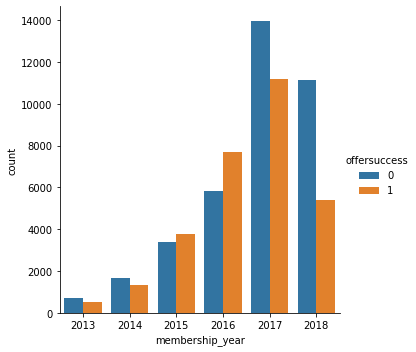

In [12]:
member_dist = offer_final_data.groupby(['membership_year','offersuccess']).count().reset_index()
sns.catplot(x='membership_year', y='time', hue='offersuccess', data=member_dist, kind='bar')
plt.ylabel('count')
plt.show()

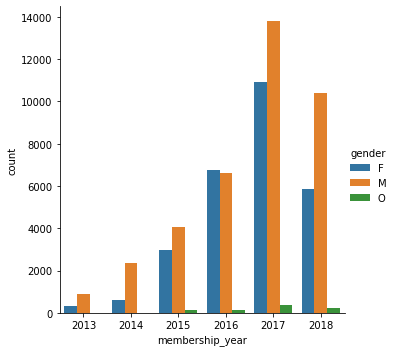

In [13]:
gender_dist = offer_final_data.groupby(['gender','membership_year']).count().reset_index()
sns.catplot(x='membership_year', y='time', hue='gender', data=gender_dist, kind='bar')
plt.ylabel('count')
plt.show()

Text(0, 0.5, 'Percent')

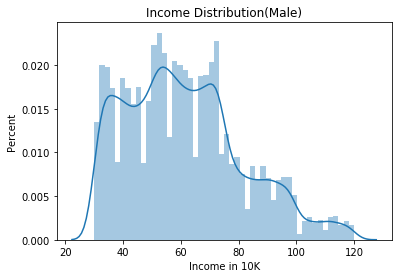

In [18]:
income_dist = offer_final_data[offer_final_data['gender']=='M']['income']*0.001
sns.distplot(income_dist)
plt.title('Income Distribution(Male)')
plt.xlabel('Income in 10K')
plt.ylabel('Percent')

Text(0, 0.5, 'Percent')

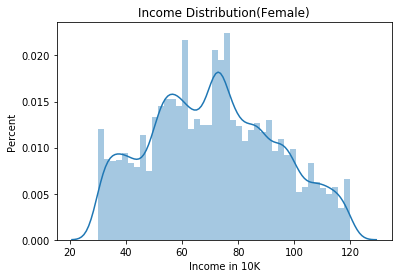

In [20]:
income_dist = offer_final_data[offer_final_data['gender']=='F']['income']*0.001
sns.distplot(income_dist)
plt.title('Income Distribution(Female)')
plt.xlabel('Income in 10K')
plt.ylabel('Percent')

**It can be observed from the above plots that customers from years 2017 and 2018 were the majority who participated in the offer promotions.<br>There are more males than other 2 gender categories, except for 2016.And for 2018 members the offers were not as successfully completed as compared to members from other years.<br>The male and female incomes are distributed between the same range(20K-120K) but most male incomes are distributed between 30-80K while female incomes are spread more uniformly between 20-40K**

###  Demographics for every offer:

In [47]:
def gen_eda(offer_loc, clean_portfolio, offer_final_data):
    '''
    INPUT:
        offer_loc: index of the offer in portfolio
        clean_portfolio: cleaned portfolio data
        offer_final_data: processed offer data from clean_offer_data() function
    OUTPUT:
        None
    '''
    offer1 = clean_portfolio.iloc[offer_loc]['offer_id']
    print('offerid:',offer1) 
    offer1_data = offer_final_data[offer_final_data['offer_id']==offer1]
    successful_offer1 = offer1_data[offer1_data['offersuccess']==1]
    unsuccessful_offer1 = offer1_data[offer1_data['offersuccess']==0]
    membership_dist = offer1_data.groupby(['membership_year','offersuccess']).count().reset_index()
    gender_dist = offer1_data.groupby(['offersuccess','gender']).count().reset_index()

    #descriptive statistics

    gender_count = offer1_data.gender.value_counts()/len(offer1_data) *100
    print('Offer was sent to {} customers'.format(len(offer1_data)))
    print('Gender Distribution Male:{}% ,Female:{}%, Other:{}% '.format(gender_count[0],gender_count[1],gender_count[2]))
    print('Offer was successful for {} customers.'.format(len(successful_offer1)))
    print('Offer was unsuccessful for {} customers.'.format(len(unsuccessful_offer1)))
    print('Success Rate : {}'.format((len(successful_offer1)/len(offer1_data))*100))

    gender_count_s = successful_offer1.gender.value_counts()/len(successful_offer1) *100
    print('\n Successful:')
    print('Average age: {}'.format(successful_offer1.age.mean()))
    print('Average income: ${}'.format(successful_offer1.income.mean()))
    
    try:
        print('Gender Distribution:')
        print('Male:{}%'.format(gender_count_s[0]))
        print('Female:{}%'.format(gender_count_s[1]))
        print('Other:{}% '.format(gender_count_s[2]))
    except:
        print('Male:{}%\nFemale:{}%\nOther:{}% '.format(0,0,0))
        
    gender_count_u = unsuccessful_offer1.gender.value_counts()/len(unsuccessful_offer1) *100
    
    print('\n Unsuccessful:')
    print('Average age: {}'.format(unsuccessful_offer1.age.mean()))
    print('Average income: ${}'.format(unsuccessful_offer1.income.mean()))
    
    try:
        print('Gender Distribution:')
        print('Male:{}%'.format(gender_count_u[0]))
        print('Female:{}%'.format(gender_count_u[1]))
        print('Other:{}% '.format(gender_count_u[2]))
    except:
        print('Male:{}%\nFemale:{}%\nOther:{}% '.format(0,0,0))
    

    #generate plots
    sns.distplot(successful_offer1['income'], label='successful')
    sns.distplot(unsuccessful_offer1['income'], label='unsuccessful')
    plt.legend()
    plt.title('Income distribution for offer')
    plt.show()
    
    sns.distplot(successful_offer1['age'], label='successful')
    sns.distplot(unsuccessful_offer1['age'], label='unsuccessful')
    plt.legend()
    plt.title('Age distribution for offer')
    plt.show()
    
    sns.catplot(x="membership_year",y="time", hue="offersuccess", kind="bar", data=membership_dist);
    plt.ylabel('Frequency')
    plt.title('Success rate Membership year wise')
    plt.show()
    
    sns.catplot(x="gender",y="time", hue="offersuccess", kind="bar", data=gender_dist);
    plt.ylabel('Frequency')
    plt.title('Success rate gender wise')
    plt.show()
    

offerid: ae264e3637204a6fb9bb56bc8210ddfd
Offer was sent to 6683 customers
Gender Distribution Male:57.459224898997455% ,Female:41.14918449797995%, Other:1.3915906030225946% 
Offer was successful for 2681 customers.
Offer was unsuccessful for 4002 customers.
Success Rate : 40.11671405057609

 Successful:
Average age: 56.096232748974266
Average income: $70805.2965311451
Gender Distribution:
Male:50.5408429690414%
Female:47.78067885117493%
Other:1.6784781797836628% 

 Unsuccessful:
Average age: 52.9287856071964
Average income: $62058.47076461769
Gender Distribution:
Male:63.943028485757125%
Female:34.8575712143928%
Other:1.199400299850075% 


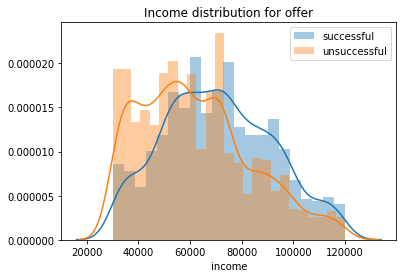

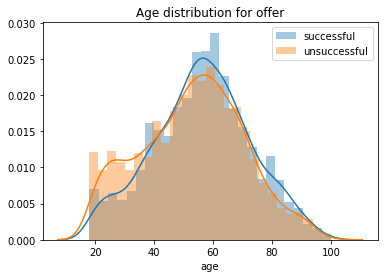

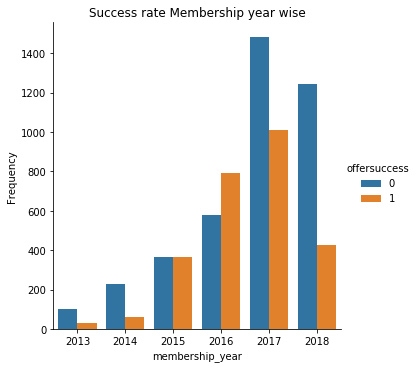

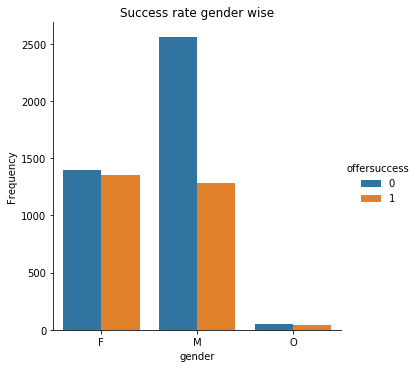

In [48]:
gen_eda(0, clean_portfolio, offer_final_data)

offerid: 4d5c57ea9a6940dd891ad53e9dbe8da0
Offer was sent to 6593 customers
Gender Distribution Male:57.39420597603518% ,Female:41.513726679811924%, Other:1.0920673441528894% 
Offer was successful for 2646 customers.
Offer was unsuccessful for 3947 customers.
Success Rate : 40.13347489761869

 Successful:
Average age: 56.87641723356009
Average income: $72405.89569160997
Gender Distribution:
Male:52.26757369614512%
Female:46.25850340136054%
Other:1.473922902494331% 

 Unsuccessful:
Average age: 52.54142386622751
Average income: $60843.67874334938
Gender Distribution:
Male:64.85938687610843%
Female:34.30453508994173%
Other:0.8360780339498353% 


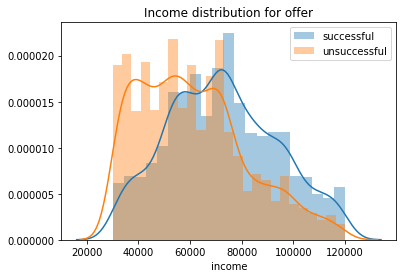

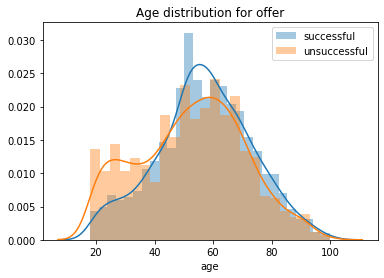

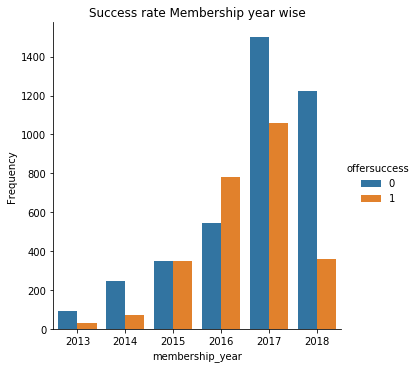

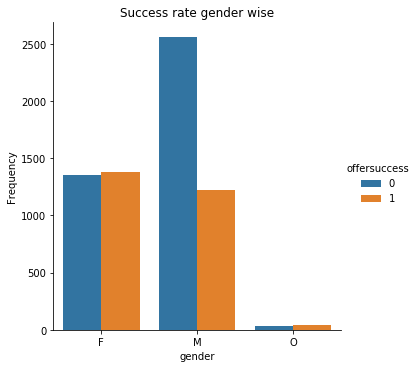

In [49]:
gen_eda(1, clean_portfolio, offer_final_data)

offerid: 3f207df678b143eea3cee63160fa8bed
Offer was sent to 6657 customers
Gender Distribution Male:57.26303139552351% ,Female:41.2948775724801%, Other:1.4420910319963949% 
Offer was successful for 2771 customers.
Offer was unsuccessful for 3886 customers.
Success Rate : 41.6253567673126

 Successful:
Average age: 56.08588957055215
Average income: $68468.06207145435
Gender Distribution:
Male:54.74557921328041%
Female:43.233489714904366%
Other:2.0209310718152294% 

 Unsuccessful:
Average age: 53.47375193000514
Average income: $62838.1369016984
Gender Distribution:
Male:59.05815748841997%
Female:39.91250643335049%
Other:1.029336078229542% 


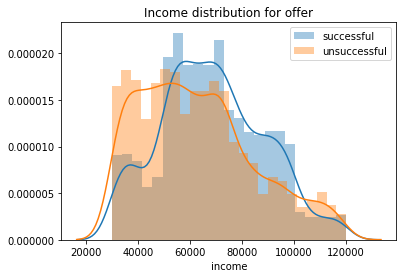

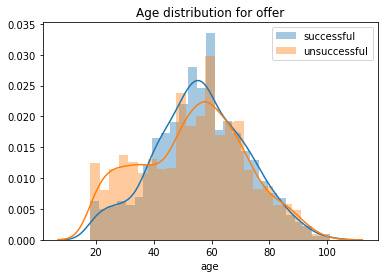

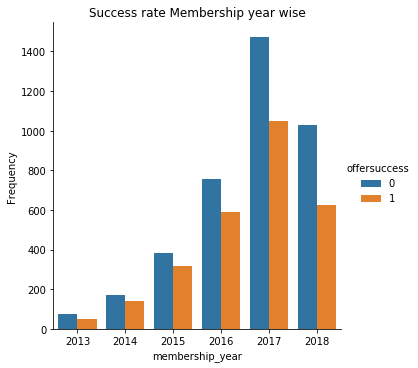

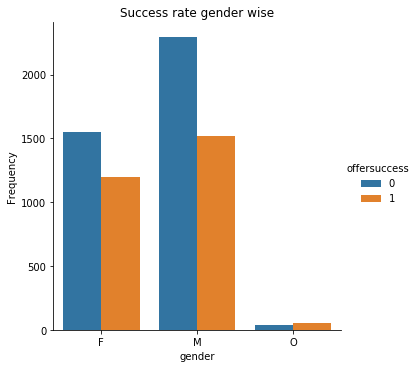

In [50]:
gen_eda(2, clean_portfolio, offer_final_data)

offerid: 9b98b8c7a33c4b65b9aebfe6a799e6d9
Offer was sent to 6685 customers
Gender Distribution Male:57.09798055347793% ,Female:41.39117427075542%, Other:1.5108451757666417% 
Offer was successful for 2243 customers.
Offer was unsuccessful for 4442 customers.
Success Rate : 33.55272999252057

 Successful:
Average age: 55.600980829246545
Average income: $68761.48016049933
Gender Distribution:
Male:51.181453410610786%
Female:46.455639768167636%
Other:2.3629068212215785% 

 Unsuccessful:
Average age: 53.75776677172445
Average income: $63334.53399369653
Gender Distribution:
Male:60.085547050877985%
Female:38.83385862224223%
Other:1.0805943268797837% 


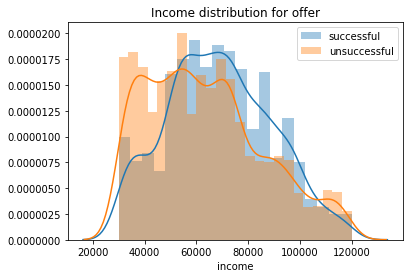

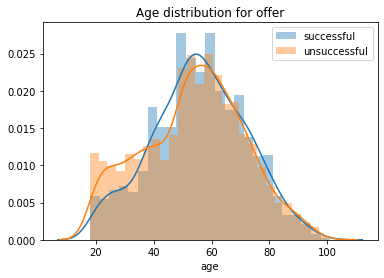

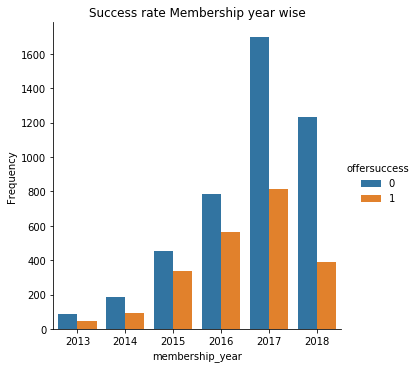

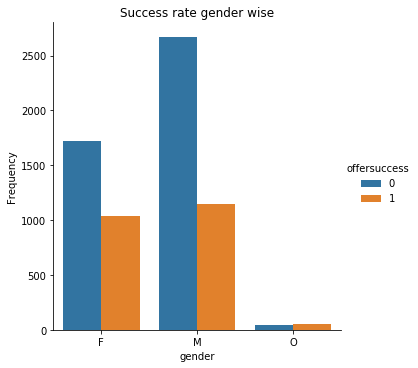

In [51]:
gen_eda(3, clean_portfolio, offer_final_data)

offerid: 0b1e1539f2cc45b7b9fa7c272da2e1d7
Offer was sent to 6726 customers
Gender Distribution Male:56.88373476063039% ,Female:41.644365150163544%, Other:1.471900089206066% 
Offer was successful for 1410 customers.
Offer was unsuccessful for 5316 customers.
Success Rate : 20.96342551293488

 Successful:
Average age: 56.96950354609929
Average income: $71492.19858156028
Gender Distribution:
Male:51.63120567375886%
Female:46.02836879432624%
Other:2.3404255319148937% 

 Unsuccessful:
Average age: 53.69525959367946
Average income: $63505.26711813393
Gender Distribution:
Male:58.276899924755455%
Female:40.481565086531226%
Other:1.2415349887133182% 


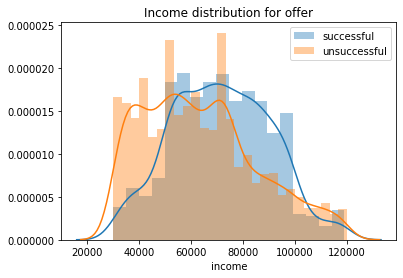

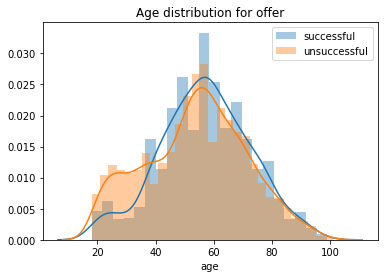

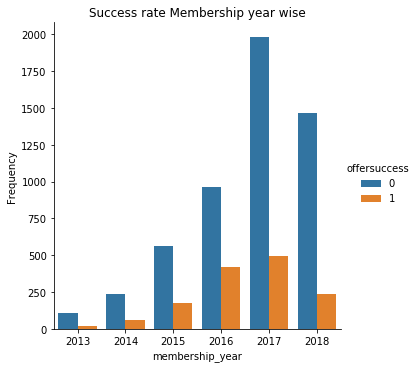

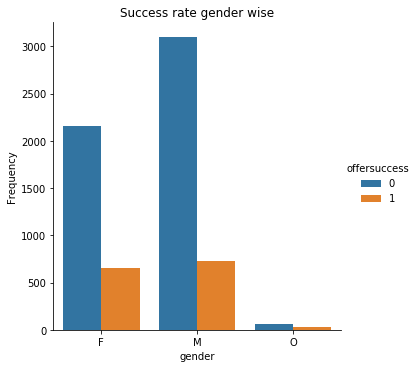

In [52]:
gen_eda(4, clean_portfolio, offer_final_data)

offerid: 2298d6c36e964ae4a3e7e9706d1fb8c2
Offer was sent to 6655 customers
Gender Distribution Male:57.77610818933133% ,Female:40.84147257700977%, Other:1.382419233658903% 
Offer was successful for 3940 customers.
Offer was unsuccessful for 2715 customers.
Success Rate : 59.20360631104433

 Successful:
Average age: 54.75253807106599
Average income: $66924.6192893401
Gender Distribution:
Male:53.55329949238579%
Female:45.0%
Other:1.4467005076142132% 

 Unsuccessful:
Average age: 53.56942909760589
Average income: $62766.11418047882
Gender Distribution:
Male:63.90423572744015%
Female:34.806629834254146%
Other:1.289134438305709% 


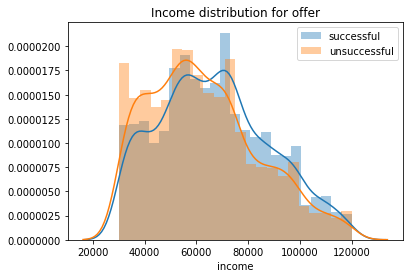

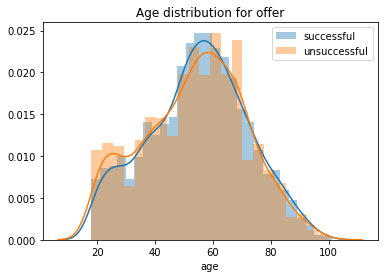

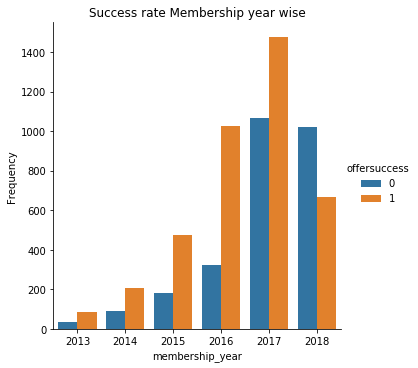

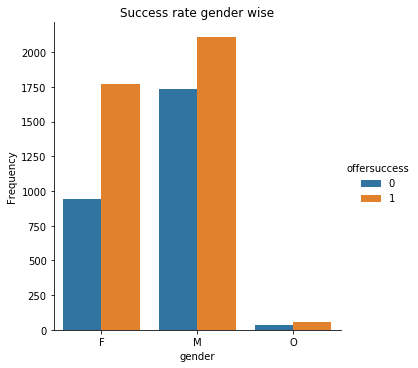

In [53]:
gen_eda(5, clean_portfolio, offer_final_data)

offerid: fafdcd668e3743c1bb461111dcafc2a4
Offer was sent to 6652 customers
Gender Distribution Male:58.14792543595912% ,Female:40.52916416115454%, Other:1.32291040288635% 
Offer was successful for 4083 customers.
Offer was unsuccessful for 2569 customers.
Success Rate : 61.38003607937462

 Successful:
Average age: 55.20034288513348
Average income: $67441.09723242714
Gender Distribution:
Male:54.49424442811658%
Female:44.20769042370806%
Other:1.2980651481753611% 

 Unsuccessful:
Average age: 53.153367068898405
Average income: $62160.76294277929
Gender Distribution:
Male:63.95484624367458%
Female:34.68275593616193%
Other:1.3623978201634876% 


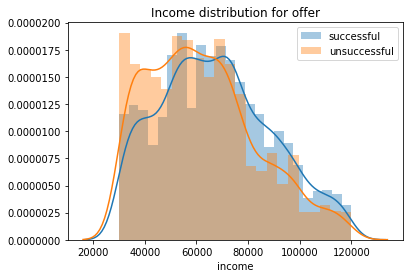

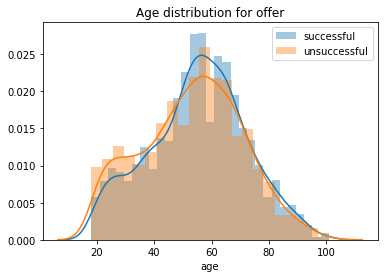

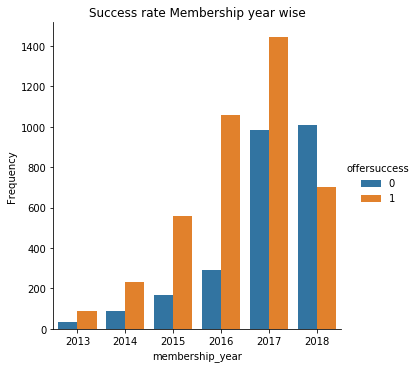

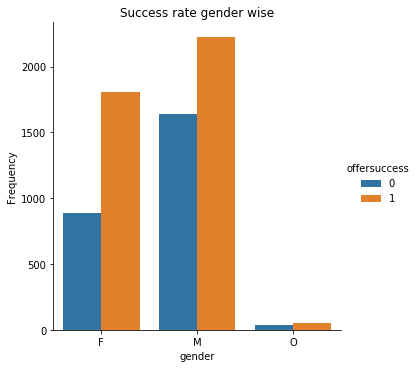

In [54]:
gen_eda(6, clean_portfolio, offer_final_data)

offerid: 5a8bc65990b245e5a138643cd4eb9837
Offer was sent to 6643 customers
Gender Distribution Male:56.52566611470721% ,Female:41.98404335390637%, Other:1.4902905313864219% 
Offer was successful for 4575 customers.
Offer was unsuccessful for 2068 customers.
Success Rate : 68.86948667770586

 Successful:
Average age: 53.54688524590164
Average income: $63188.19672131148
Gender Distribution:
Male:58.31693989071039%
Female:40.021857923497265%
Other:1.6612021857923498% 

 Unsuccessful:
Average age: 56.79690522243714
Average income: $70814.31334622824
Gender Distribution:
Male:52.562862669245646%
Female:46.32495164410058%
Other:1.1121856866537718% 


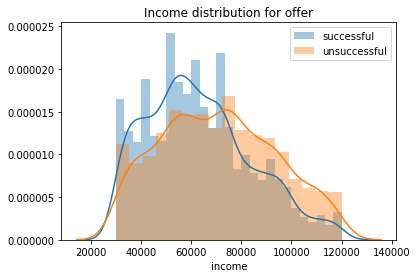

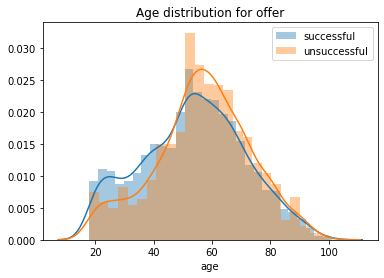

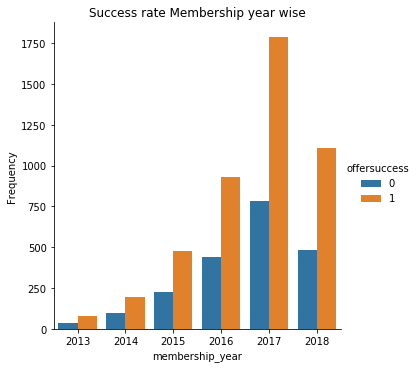

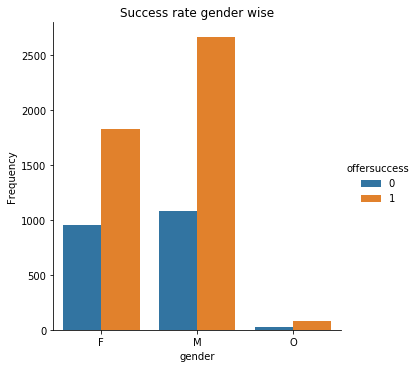

In [55]:
gen_eda(7, clean_portfolio, offer_final_data)

offerid: f19421c1d4aa40978ebb69ca19b0e20d
Offer was sent to 6576 customers
Gender Distribution Male:57.28406326034063% ,Female:41.377737226277375%, Other:1.338199513381995% 
Offer was successful for 3284 customers.
Offer was unsuccessful for 3292 customers.
Success Rate : 49.93917274939172

 Successful:
Average age: 55.54780755176614
Average income: $68519.79293544458
Gender Distribution:
Male:51.9183922046285%
Female:46.37637028014616%
Other:1.705237515225335% 

 Unsuccessful:
Average age: 53.40461725394897
Average income: $62474.48359659781
Gender Distribution:
Male:62.63669501822601%
Female:36.391251518833535%
Other:0.9720534629404617% 


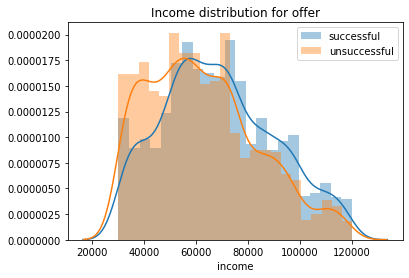

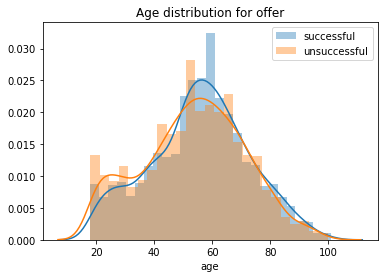

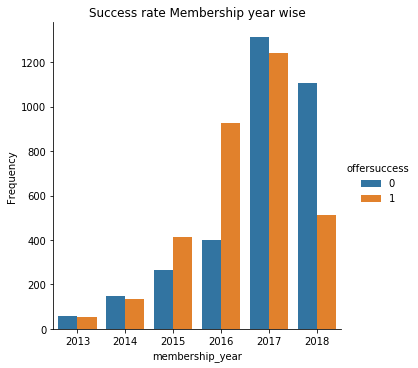

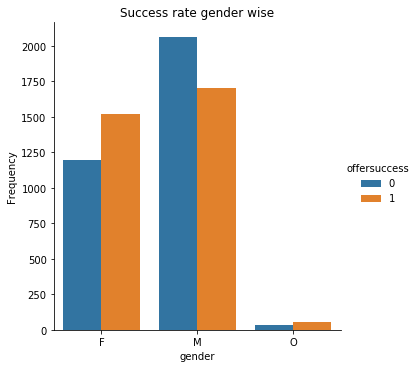

In [56]:
gen_eda(8, clean_portfolio, offer_final_data)

offerid: 2906b810c7d4411798c6938adc9daaa5
Offer was sent to 6631 customers
Gender Distribution Male:57.53280048258181% ,Female:41.14009953249887%, Other:1.3270999849193184% 
Offer was successful for 2226 customers.
Offer was unsuccessful for 4405 customers.
Success Rate : 33.56959734580003

 Successful:
Average age: 56.276729559748425
Average income: $69628.03234501347
Gender Distribution:
Male:52.38095238095239%
Female:45.64240790655885%
Other:1.9766397124887691% 

 Unsuccessful:
Average age: 53.12099886492622
Average income: $63365.72077185017
Gender Distribution:
Male:60.13620885357548%
Female:38.86492622020432%
Other:0.9988649262202044% 


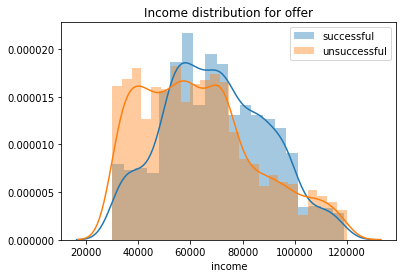

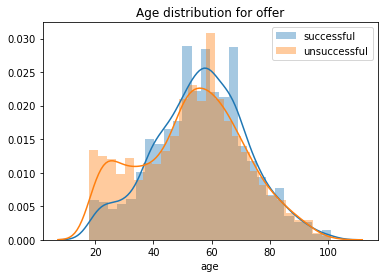

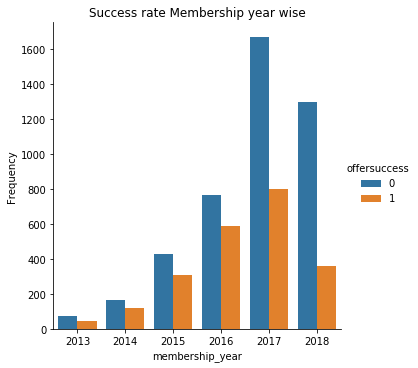

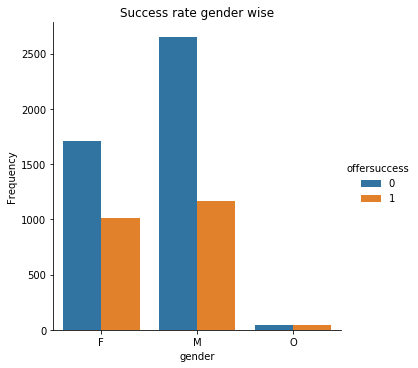

In [57]:
gen_eda(9, clean_portfolio, offer_final_data)

**The offers received poor response from customers who became members in 2018 than others.<br>
The age and income are usually high for those customers who responded to offers as compared to who did not.**

###  Train a model

**A randomforest classifier has been trained to determine whether an offer would be successful or not by providing customer profile and offer details as input variables.<br>
The data is divided into 1/3 test and 2/3 train splits.
Sklearn pipeline with Minmaxscaler transformer and rf classifier is created and gridsearched across a few parameters.<br>
Cross validation is done 5 times while fitting on training split.<br>
The accuracy and f1-score are the metrics used to evaluate the model.**

In [58]:
offer_final_data.columns

Index(['time', 'person', 'offer_id', 'gender', 'age', 'income', 'date',
       'membership_year', '2013', '2014', '2015', '2016', '2017', '2018',
       'gender_F', 'gender_M', 'gender_O', 'reward', 'difficulty', 'duration',
       'bogo', 'discount', 'informational', 'email', 'mobile', 'social', 'web',
       'offersuccess'],
      dtype='object')

In [84]:
drop_columns = ['time','person','offer_id','gender','date',
                'membership_year','offersuccess','gender_O','informational','email']
offer_final_data = shuffle(offer_final_data)
y = offer_final_data['offersuccess']
X = offer_final_data.drop(columns=drop_columns, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

pipeline = Pipeline([
    ('minmax',MinMaxScaler()),
    ('clf', RandomForestClassifier())
    ])
    
parameters = {
    'clf__n_estimators':[200,250,300,350,499],
    'clf__max_depth':[x for x in range(4,15)],
    'clf__min_samples_split':[2,5,10],
    'clf__min_samples_leaf':[1,2,4],
    
}

cv = GridSearchCV(pipeline,param_grid=parameters, cv =5, verbose=0)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('minmax',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                 

### Best Estimator

In [85]:
cv.best_estimator_

Pipeline(memory=None,
         steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=10, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=4, min_samples_split=5,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=499, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [86]:
y_pred=cv.predict(X_test)

In [87]:
accuracy = accuracy_score(y_test, y_pred)
f1_scores = f1_score(y_test, y_pred)

accuracy, f1_scores

(0.6717540034583865, 0.6094812164579606)

In [88]:
Y_pred_train = cv.predict(X_train)
accuracy = accuracy_score(y_train, Y_pred_train)
f1_scores = f1_score(y_train, Y_pred_train)

accuracy, f1_scores

(0.6888345864661655, 0.6363356766256589)

**The training and testing accuracy and f1-score seem to be close enough providing us support that the model is performing good. There needs to a lot more improvement to be done to this model.**

### Features arranged by importance

In [89]:
feature_importance=pd.DataFrame(data = cv.best_estimator_.named_steps['clf'].feature_importances_,
                                index = X_train.columns,
                                columns=['importance'])
feature_importance.sort_values(by='importance', ascending=False)

,importance
income,0.198608
social,0.141276
age,0.112804
2018,0.086073
duration,0.082084
reward,0.078252
difficulty,0.060609
2016,0.055042
mobile,0.033369
bogo,0.031653


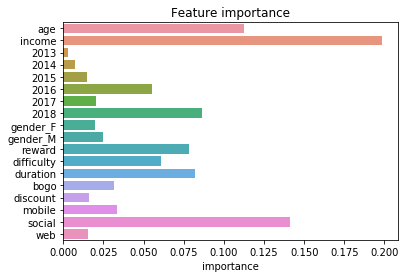

In [91]:
sns.barplot(y=feature_importance.index,x=feature_importance['importance'], orient='h')
plt.title('Feature importance')
plt.show()

### Conclusion:

The Randomforest classifier trained has very less difference in the training data and testing data accuracy, thus suggesting that the model did not overfit. 
As per the best estimator found by the Grid search the top five features of the model are:

1. Income of customer
2. Whether the offer is shared on social platform
3. Age of the customer
4. 2018 membership 
5. Offer Duration

A more improved model can be obtained by creating new features that may describe the success of offer as a function of the top important features.